In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
data = pd.read_csv('data_with_100.csv', sep='\t', usecols=['Author', 'Thread Entry Type', 'Thread Author', 'Account Type', 'UserType', 'Ethnicity', 'gender_inferred'])

C:\Users\mikeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
with open('user2demographics.json') as f:
    u2d = json.load(f)

In [4]:
data.loc[data['Thread Entry Type'] != 'post', 'Origin Ethnicity'] = data.loc[data['Thread Entry Type'] != 'post', 'Thread Author'].map(lambda x: u2d.get(x).get('ethnicity') if u2d.get(x) else None)
data.loc[data['Thread Entry Type'] != 'post', 'Origin Gender'] = data.loc[data['Thread Entry Type'] != 'post', 'Thread Author'].map(lambda x: u2d.get(x).get('gender') if u2d.get(x) else None)
data.loc[data['Thread Entry Type'] != 'post', 'Origin Intersectional'] = data.loc[data['Thread Entry Type'] != 'post', 'Thread Author'].map(lambda x: u2d.get(x).get('Intersectional') if u2d.get(x) else None)
data.loc[data['Thread Entry Type'] != 'post', 'Origin Type'] = data.loc[data['Thread Entry Type'] != 'post', 'Thread Author'].map(lambda x: u2d.get(x).get('Type') if u2d.get(x) else None)

In [22]:
data.UserType.value_counts()

business     574
celebrity    567
Name: UserType, dtype: int64

In [5]:
organisations = data[(data['Account Type'] == 'organisational') & (data['UserType'] != 'business')]
individuals = data[(data['Account Type'] == 'individual') & (data['UserType'] != 'celebrity')]
celebrities = data[data['UserType'] == 'celebrity']
businesses = data[data['UserType'] == 'business']

In [6]:
genders = ['male', 'female']
ethnicities = ['Caucasian', 'African American', 'Hispanic', 'Asian']
intersectional = []

for gender in genders:
    for eth in ethnicities:
        new_df = individuals[(individuals['gender_inferred'] == gender) & (individuals['Ethnicity'] == eth)]
        name = f"{eth} {gender}"
        intersectional.append((name, new_df))
        
for i, gender in enumerate(genders):
    genders[i] = (gender, individuals[individuals['gender_inferred'] == gender])

for i, eth in enumerate(ethnicities):
    ethnicities[i] = (eth, individuals[individuals['Ethnicity'] == eth])

In [7]:
types = [('individual', individuals), ('organisational', organisations), ('celebrity', celebrities), ('business', businesses)]


In [8]:
total = [types, genders, ethnicities, intersectional]
all_groups = types + genders + ethnicities + intersectional
total_names = []
for group in total:
    total_names += [x[0] for x in group]

print(total_names)


['individual', 'organisational', 'celebrity', 'business', 'male', 'female', 'Caucasian', 'African American', 'Hispanic', 'Asian', 'Caucasian male', 'African American male', 'Hispanic male', 'Asian male', 'Caucasian female', 'African American female', 'Hispanic female', 'Asian female']


In [9]:
def calculate_pmi(given, target, focus, entry_type=None):
    given = given[1][given[1]['Thread Entry Type'] != 'post'] if not entry_type else given[1][given[1]['Thread Entry Type'] == entry_type]
    p_target = len(target[1]) / len(data)
    conditional = given[f'Origin {focus}'].value_counts().get(target[0], 0) / len(given)
    return np.log(conditional / p_target)


In [10]:
def calc_crosswise_pmis(entry_type=None):
    total_pmis = []
    for given in all_groups:
        pmis = []
        for target in total[0]:
            pmis.append(calculate_pmi(given, target, 'Type', entry_type))
        for target in total[1]:
            pmis.append(calculate_pmi(given, target, 'Gender', entry_type))
        for target in total[2]:
            pmis.append(calculate_pmi(given, target, 'Ethnicity', entry_type))
        for target in total[3]:
            pmis.append(calculate_pmi(given, target, 'Intersectional', entry_type))
        total_pmis.append(pmis)
    return total_pmis
        

In [11]:
total_pmis = calc_crosswise_pmis()

<ipython-input-9-bcb93a84649d>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(conditional / p_target)


In [12]:
share_pmis = calc_crosswise_pmis('share')

<ipython-input-9-bcb93a84649d>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(conditional / p_target)


In [13]:
reply_pmis = calc_crosswise_pmis('reply')

<ipython-input-9-bcb93a84649d>:5: RuntimeWarning: divide by zero encountered in log
  return np.log(conditional / p_target)


In [14]:
def get_pmi(pmis, given, target):
    return pmis[idx[given]][idx[target]]

In [15]:
import matplotlib.pyplot as plt

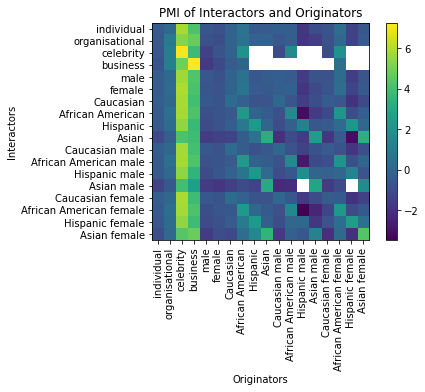

In [16]:
plt.imshow(total_pmis)
plt.title('PMI of Interactors and Originators')
plt.xlabel('Originators')
plt.ylabel('Interactors')
plt.xticks(ticks=[_ for _ in range(len(total_names))], labels=total_names, rotation=90)
plt.yticks(ticks=[_ for _ in range(len(total_names))], labels=total_names)
plt.colorbar()
plt.show()

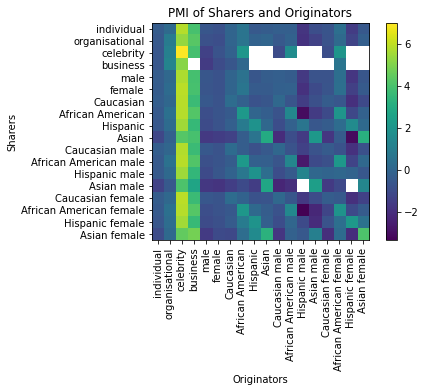

In [17]:
plt.imshow(share_pmis)
plt.title('PMI of Sharers and Originators')
plt.xlabel('Originators')
plt.ylabel('Sharers')
plt.xticks(ticks=[_ for _ in range(len(total_names))], labels=total_names, rotation=90)
plt.yticks(ticks=[_ for _ in range(len(total_names))], labels=total_names)
plt.colorbar()
plt.show()

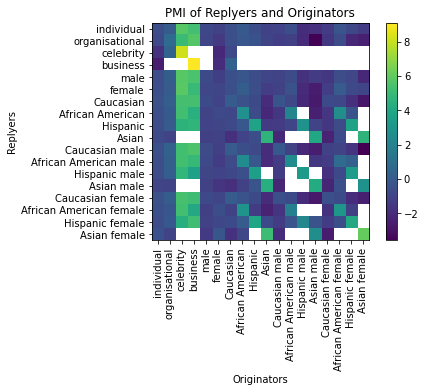

In [18]:
plt.imshow(reply_pmis)
plt.title('PMI of Replyers and Originators')
plt.xlabel('Originators')
plt.ylabel('Replyers')
plt.xticks(ticks=[_ for _ in range(len(total_names))], labels=total_names, rotation=90)
plt.yticks(ticks=[_ for _ in range(len(total_names))], labels=total_names)
plt.colorbar()
plt.show()

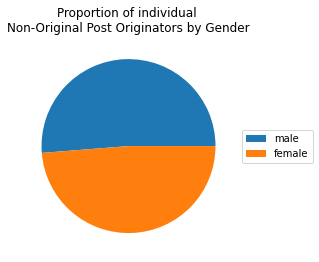

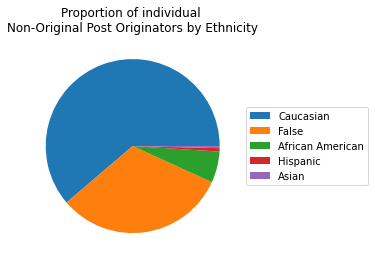

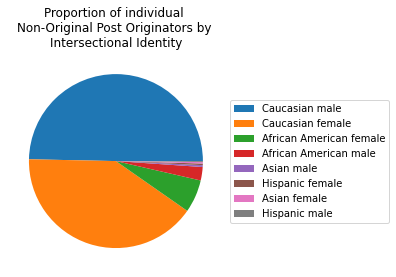

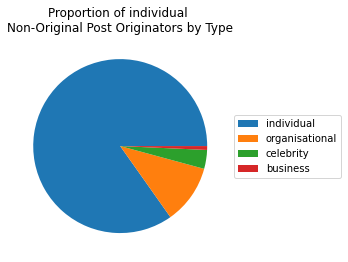

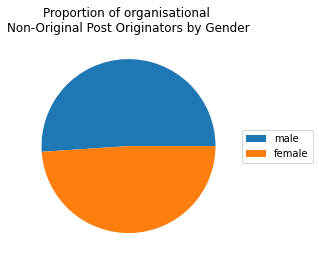

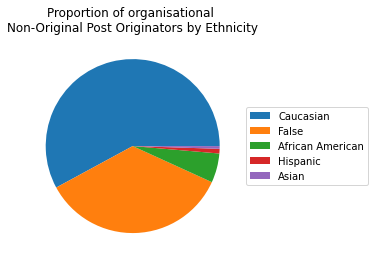

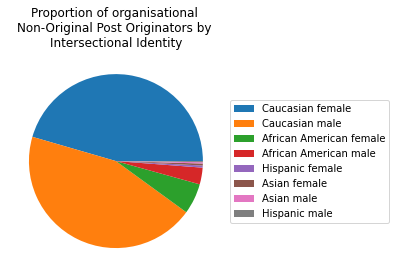

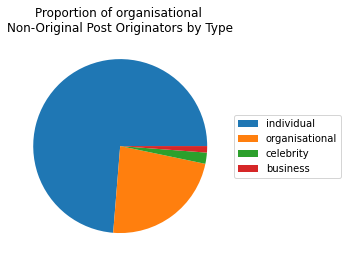

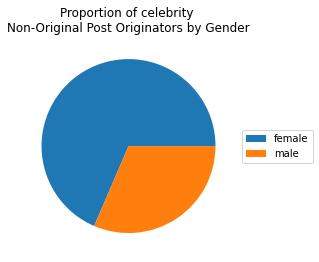

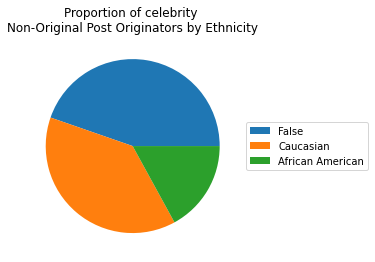

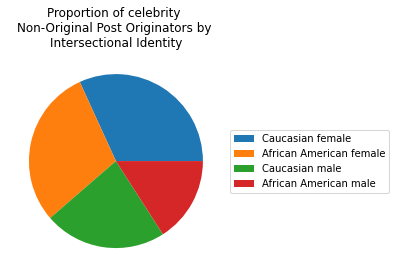

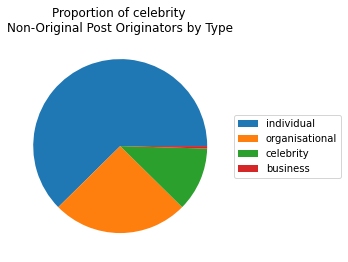

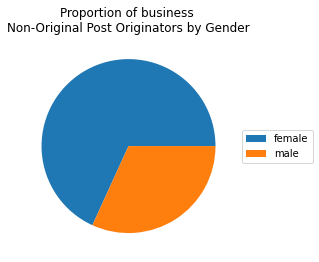

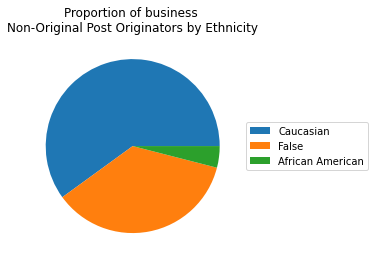

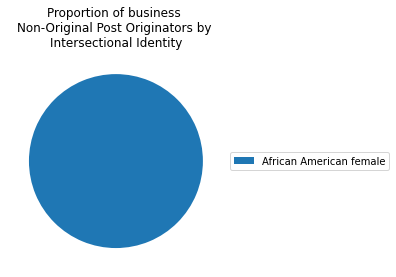

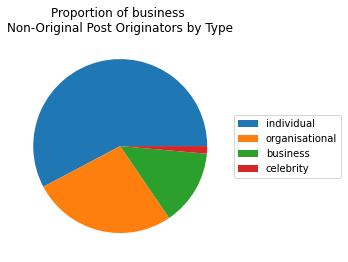

In [19]:
for name, df in types:
    counts = df['Origin Gender'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nNon-Original Post Originators by Gender')
    plt.legend(labels = counts.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Ethnicity'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nNon-Original Post Originators by Ethnicity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Intersectional'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nNon-Original Post Originators by \nIntersectional Identity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Type'].value_counts()
    plt.pie(counts.values)
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Proportion of {name} \nNon-Original Post Originators by Type')
    plt.show()

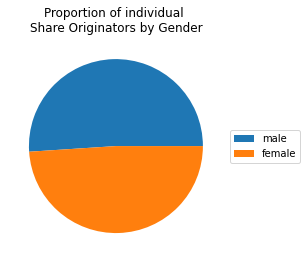

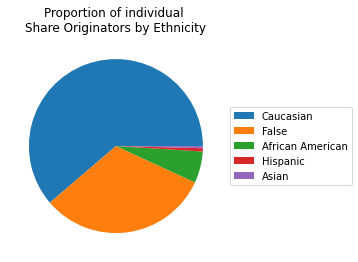

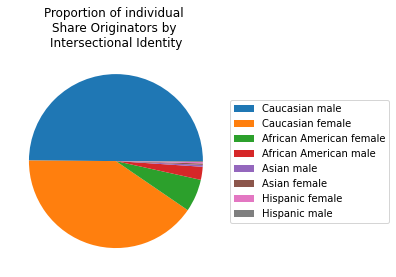

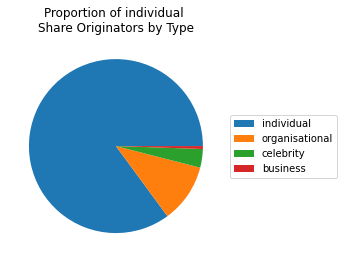

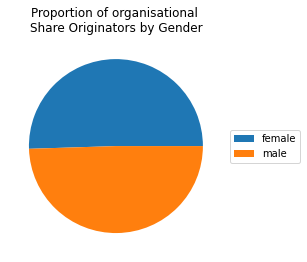

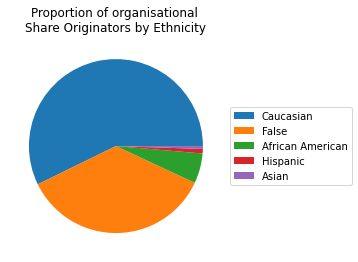

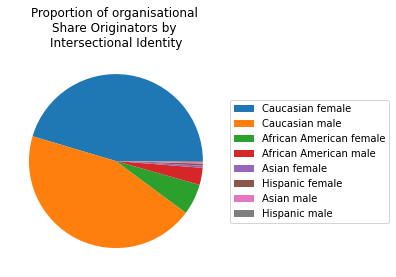

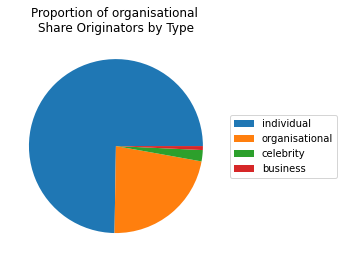

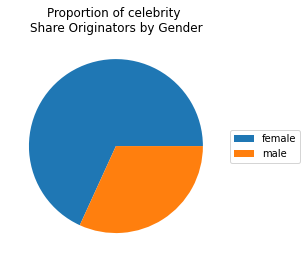

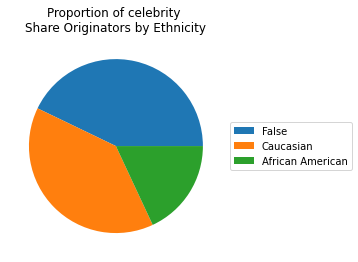

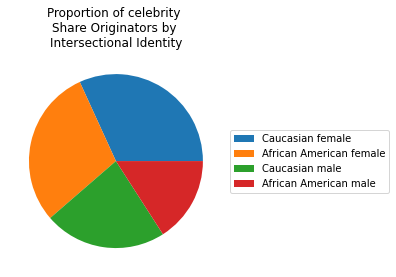

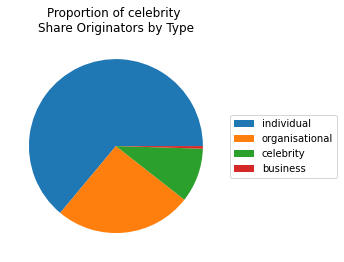

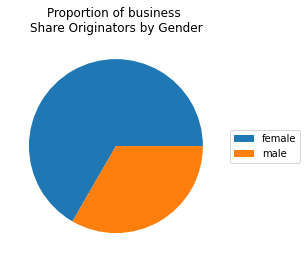

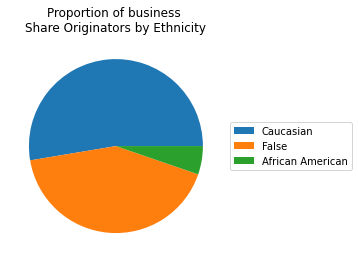

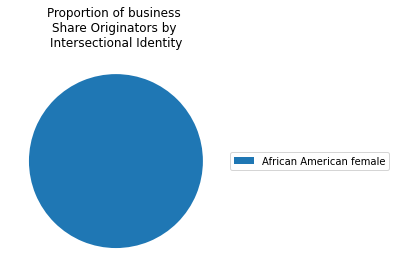

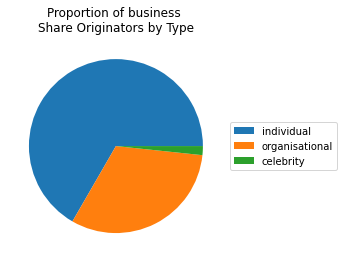

In [20]:
for name, df in types:
    df = df[df['Thread Entry Type'] == 'share']
    counts = df['Origin Gender'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nShare Originators by Gender')
    plt.legend(labels = counts.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Ethnicity'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nShare Originators by Ethnicity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Intersectional'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nShare Originators by \nIntersectional Identity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Type'].value_counts()
    plt.pie(counts.values)
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Proportion of {name} \nShare Originators by Type')
    plt.show()

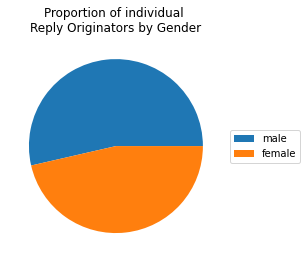

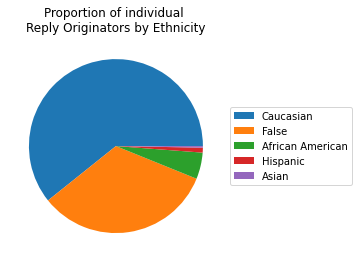

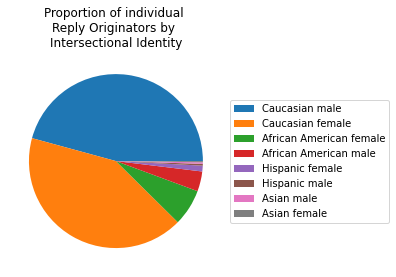

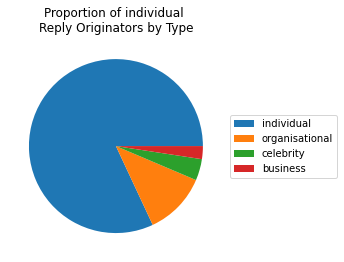

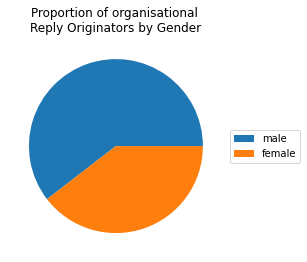

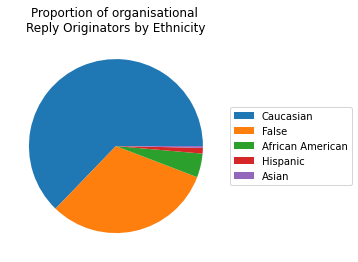

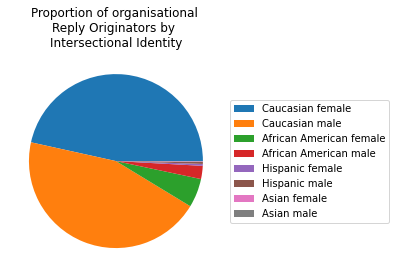

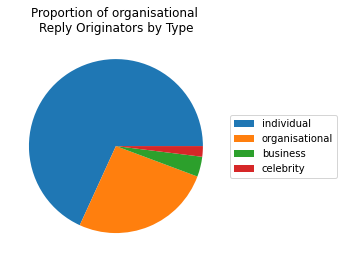

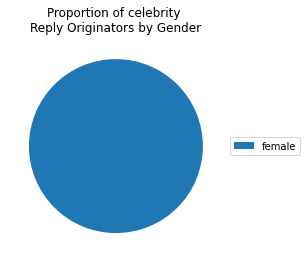

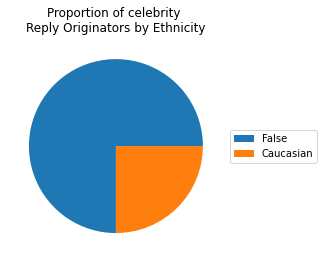

<ipython-input-21-3e1278a71a03>:14: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(counts.values)


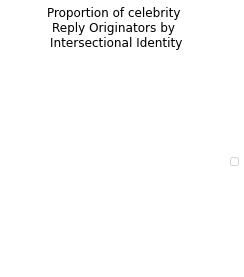

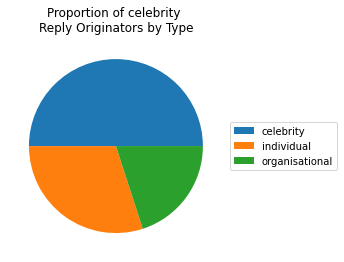

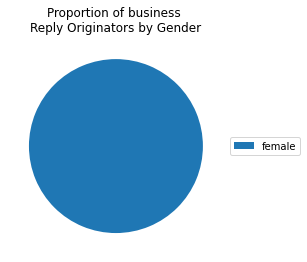

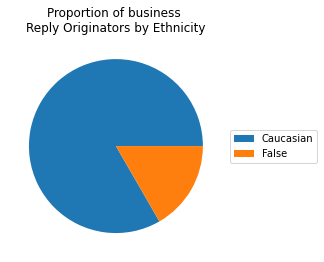

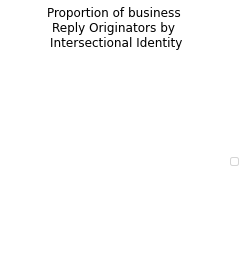

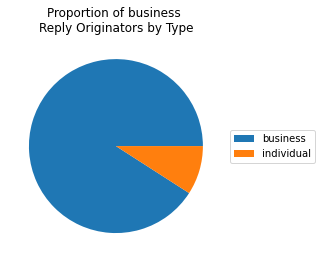

In [21]:
for name, df in types:
    df = df[df['Thread Entry Type'] == 'reply']
    counts = df['Origin Gender'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nReply Originators by Gender')
    plt.legend(labels = counts.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Ethnicity'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nReply Originators by Ethnicity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Intersectional'].value_counts()
    plt.pie(counts.values)
    plt.title(f'Proportion of {name} \nReply Originators by \nIntersectional Identity')
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    counts = df['Origin Type'].value_counts()
    plt.pie(counts.values)
    plt.legend(labels = counts.keys(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Proportion of {name} \nReply Originators by Type')
    plt.show()